# Community Detection in Genomics with NetworkX using Louvain on CPU or Leiden on GPU from nx-cugraph

This notebook demonstrates an application of community detection in a genomics workflow using NetworkX.

The nx-cugraph backend is used to enable the GPU-accelerated Leiden algorithm to showcase massive speedup with comparable results when compared to the native Louvain implementation.

This notebook loads a gene expression dataset, computes a correlation matrix, builds a gene co-expression network, and detects communities using the Leiden or Louvain algorithm before plotting the results for visual inspection.

We'll first import the required modules. Note the `nx-cugraph` package is also installed in this environment, but need not be explicitly imported. Instead, `nx-cugraph` is enabled as a NetworkX backend through the environment variable setting `NX_CUGRAPH_AUTOCONFIG=True`, which is only evaluated once and must be set prior to importing `networkx`.

To install `nx-cugraph` using `conda` or `pip` use the [RAPIDS install selector](https://docs.rapids.ai/install/#install-rapids), and for more detailed instructions including install requirements refer to the [RAPIDS installation guide](https://docs.rapids.ai/install/). To install from source, refer to the [nx-cugraph GitHub repo](https://github.com/rapidsai/nx-cugraph).

In [ ]:
%env NX_CUGRAPH_AUTOCONFIG=True
from pathlib import Path
import requests
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

env: NX_CUGRAPH_AUTOCONFIG=True


## Load and preprocess the gene expression data
Information about the gene expression data can be found [here](https://figshare.com/articles/dataset/Gene_expression_csv_files/21861975?file=38793663).

In [ ]:
%%time
url = "https://figshare.com/ndownloader/files/38793663"
csv_file_name = Path("CreNegHyperoxiavsCreNegNormoxia_all_detectable_genes.csv")
if not csv_file_name.exists():
    print(f"Downloading {url} to {csv_file_name}...")
    req = requests.get(url)
    csv_file_name.write_bytes(req.content)
    print("Download complete.")
else:
    print(f"File {csv_file_name} already exists, skipping download.")
df = pd.read_csv(csv_file_name).drop(["NAME", "Foldchange", "PValue", "FDR"], axis=1)
df

CPU times: user 58.3 ms, sys: 17.1 ms, total: 75.4 ms
Wall time: 73.8 ms


,Gene_symbol,1negH,2negH,3negH,4negH,5negH,6negH,1negN,2negN,3negN,4negN,5negN,6negN
0,0610007P14Rik,21.029999,24.146191,19.102242,20.951491,20.477456,19.736071,21.467147,20.915478,19.726746,14.117321,20.646162,19.674725
1,0610009B22Rik,12.474068,12.291472,12.133346,11.639717,11.900859,11.783808,11.868855,11.557070,13.337265,9.694298,12.153082,12.277833
2,0610009L18Rik,1.199430,1.310258,0.746667,0.440422,1.329705,1.662746,0.877263,1.183895,1.612879,1.151198,1.173077,1.459251
3,0610009O20Rik,39.461234,40.368439,39.946707,39.889625,39.292780,36.941877,46.959384,45.833649,34.738924,45.078485,47.955404,49.815800
4,0610010B08Rik,32.744429,43.612888,31.111143,22.398591,22.073102,24.796602,24.769785,38.843031,32.257572,23.508672,35.896168,43.777521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14668,Zyg11b,135.255680,129.278834,143.173478,142.822475,139.619016,124.778238,152.282574,160.953344,108.000833,176.072686,156.441600,159.360240
14669,Zyx,231.729803,238.903791,198.489089,235.877294,207.566937,187.528824,285.781395,262.711938,225.989107,343.359914,244.469327,265.080437
14670,Zzef1,83.880111,83.107822,92.337871,81.855524,85.832452,72.799354,82.772365,82.759898,68.609375,93.974100,83.898495,86.850576
14671,Zzz3,123.181422,119.982238,129.546797,121.870984,124.659836,113.717363,111.876862,118.558628,88.025952,120.027526,113.929276,120.212066


Transpose the DataFrame in order to generate a correlation matrix.

In [3]:
%%time
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]
df

CPU times: user 4.99 ms, sys: 1.85 ms, total: 6.84 ms
Wall time: 6.43 ms


Gene_symbol,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1negH,21.029999,12.474068,1.19943,39.461234,32.744429,29.98574,15.632566,8.036178,12.633992,62.050492,...,8.91576,45.018592,20.790113,28.706349,33.823915,135.25568,231.729803,83.880111,123.181422,16.911958
2negH,24.146191,12.291472,1.310258,40.368439,43.612888,33.380394,15.972674,9.795742,13.664124,55.904361,...,8.61027,49.103495,22.96072,30.323124,30.697484,129.278834,238.903791,83.107822,119.982238,18.780371
3negH,19.102242,12.133346,0.746667,39.946707,31.111143,34.657813,14.808904,7.528896,12.071123,57.617836,...,7.653341,44.364489,20.346687,28.497807,31.04892,143.173478,198.489089,92.337871,129.546797,15.431127
4negH,20.951491,11.639717,0.440422,39.889625,22.398591,33.094547,15.66643,9.500526,12.709313,53.102277,...,6.165904,49.704738,20.322317,29.067834,32.52829,142.822475,235.877294,81.855524,121.870984,15.603513
5negH,20.477456,11.900859,1.329705,39.29278,22.073102,30.782669,16.089429,8.310656,13.363534,48.534229,...,6.515554,47.27101,21.275279,31.04861,29.585934,139.619016,207.566937,85.832452,124.659836,15.956459
6negH,19.736071,11.783808,1.662746,36.941877,24.796602,34.483905,20.314418,9.036663,13.301967,56.316482,...,6.723277,45.906246,20.242124,25.230362,27.037695,124.778238,187.528824,72.799354,113.717363,15.253887
1negN,21.467147,11.868855,0.877263,46.959384,24.769785,30.291383,19.454602,5.366787,12.126874,52.687397,...,7.534143,29.723742,18.835357,27.19516,30.704213,152.282574,285.781395,82.772365,111.876862,22.75724
2negN,20.915478,11.55707,1.183895,45.833649,38.843031,35.009466,17.871177,7.216122,10.655055,57.390719,...,8.569145,28.300728,17.251041,32.359797,28.526232,160.953344,262.711938,82.759898,118.558628,20.182591
3negN,19.726746,13.337265,1.612879,34.738924,32.257572,25.68199,30.644694,9.987441,17.49353,53.473129,...,9.429136,27.108767,25.806058,27.729105,27.418936,108.000833,225.989107,68.609375,88.025952,16.749124
4negN,14.117321,9.694298,1.151198,45.078485,23.508672,29.082894,20.115668,6.422472,10.906085,46.714398,...,9.694298,30.537038,22.721011,37.747172,25.083996,176.072686,343.359914,93.9741,120.027526,18.782702


Generate the correlation matrix. The correlation matrix allows us to measure the similarity of each gene to every other gene based on the similarity of their expression values.

In [4]:
%%time
cm = df.corr()
print(f"correlation matrix shape: {cm.shape}")
cm

correlation matrix shape: (14673, 14673)
CPU times: user 6.24 s, sys: 190 ms, total: 6.43 s
Wall time: 6.43 s


Gene_symbol,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,1.000000,0.654730,-0.032898,-0.115824,0.413583,0.307951,-0.254081,0.340229,0.251359,0.437785,...,-0.231645,0.342763,-0.159523,-0.548745,0.631587,-0.461406,-0.478918,-0.373224,-0.010052,0.103632
0610009B22Rik,0.654730,1.000000,0.273219,-0.356026,0.414474,-0.159859,0.277730,0.446222,0.737879,0.553768,...,-0.105149,0.045430,0.221927,-0.737408,0.442109,-0.744975,-0.651684,-0.595764,-0.428483,-0.072699
0610009L18Rik,-0.032898,0.273219,1.000000,-0.175571,0.319760,-0.285220,0.536650,0.242670,0.471021,0.121091,...,0.170069,-0.248465,0.331362,-0.121872,-0.521899,-0.356649,-0.154415,-0.479709,-0.473448,0.036256
0610009O20Rik,-0.115824,-0.356026,-0.175571,1.000000,0.345184,0.196113,-0.280649,-0.801039,-0.585589,0.163544,...,-0.131129,-0.587087,-0.565516,0.353836,-0.038328,0.849004,0.643119,0.533064,0.268170,0.881709
0610010B08Rik,0.413583,0.414474,0.319760,0.345184,1.000000,0.203992,-0.032472,0.064455,0.086956,0.683210,...,0.143470,-0.277693,-0.071530,-0.027865,0.142927,0.012628,0.012431,0.006088,-0.032395,0.456834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11b,-0.461406,-0.744975,-0.356649,0.849004,0.012628,0.226686,-0.407689,-0.793181,-0.828120,-0.137014,...,-0.021179,-0.402780,-0.532013,0.673214,-0.168878,1.000000,0.735252,0.771263,0.496100,0.566039
Zyx,-0.478918,-0.651684,-0.154415,0.643119,0.012431,-0.320090,0.101023,-0.588062,-0.445688,-0.351882,...,0.381059,-0.577267,-0.054756,0.709816,-0.339104,0.735252,1.000000,0.448430,-0.018865,0.606892
Zzef1,-0.373224,-0.595764,-0.479709,0.533064,0.006088,0.245707,-0.660804,-0.565687,-0.733372,-0.118555,...,-0.012564,0.042401,-0.307789,0.624758,0.121754,0.771263,0.448430,1.000000,0.784901,0.195851


Convert to a NumPy array for easy and fast lookup when building the graph below.

In [5]:
cm = cm.to_numpy()
(num_rows, num_cols) = cm.shape
col_names = df.columns.tolist()
del df

## Build the graph from the correlation matrix

The correlation matrix values represent how strong the relationship is between genes. We can build a graph using the correlation matrix where each gene represents a node, and the relationship between genes as measured by the correlation coefficients are the weighted edges.

In [ ]:
%%time
edge_indices = [(i, j) for i in range(num_rows) for j in range(num_cols) if i != j]
edges = np.empty((len(edge_indices), 3), dtype=object)
edgeno = 0
for i, j in tqdm(edge_indices, desc="Processing edges"):
    # The absolute value of the correlation coefficient is used to represent the weight of the edge, because even a negative correlation represents a relationship between two genes.
    weight = abs(cm[i, j])
    if weight > 0.5: # Set a threshold for significance
        edges[edgeno] = (col_names[i], col_names[j], weight)
        edgeno += 1
# Convert to a Pandas DataFrame with correct column names and dtypes for easy conversion to a NetworkX Graph.
edges = pd.DataFrame(edges[:edgeno], columns=["source", "target", "weight"])
edges = edges.astype({"source": str, "target": str, "weight": float})

Processing edges: 100%|███████████████████████████████████████████| 215282256/215282256 [02:21<00:00, 1525468.92it/s]


CPU times: user 2min 40s, sys: 10.2 s, total: 2min 50s
Wall time: 2min 49s


In [7]:
%%time
G = nx.from_pandas_edgelist(edges, edge_attr="weight")
print(f"graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

del cm, col_names, edges, edge_indices

graph has 14673 nodes and 83824080 edges
CPU times: user 2min 48s, sys: 5.2 s, total: 2min 53s
Wall time: 2min 51s


## Community detection (Leiden or Louvain)

Now that we have a graph, we can use the huge selection of graph algorithms available in NetworkX to analyze it. In this case, we're interested in understanding if there are communities or clusters of similar genes. If the genes have a strong relationship to each other, it stands to reason that they're likely functionally similar. NetworkX has several community detection algorithms, but Leiden stands out as a popular choice for this analysis due to its ability to return only connected communities.

Note that Leiden is currently the only algorithm provided by nx-cugraph that does not have an alternative implementation available through NetworkX. This means that Leiden is available to NetworkX users only through nx-cugraph. For this reason, this notebook uses Louvain from NetworkX on CPU, as it provides a reasonable comparison for a user wishing to continue using NetworkX when a GPU is not present.

In [8]:
%%time
try:
    communities = nx.community.leiden_communities(G)
except NotImplementedError:
    print("leiden not available (is the cugraph backend enabled?), using louvain.")
    communities = nx.community.louvain_communities(G)

num_communities = len(communities)
print(f"Number of communities: {num_communities}")

Number of communities: 4
CPU times: user 3.44 s, sys: 546 ms, total: 3.99 s
Wall time: 4.03 s


Lets examine the communities returned by looking at the first 10 genes, sorted by name.

In [9]:
for i, com in enumerate(communities):
    print(f"community {i} has {len(com)} genes")
    scom = sorted(list(com))
    print(f"first 10 genes: {scom[:10]}\n")

community 0 has 5056 genes
first 10 genes: ['0610009O20Rik', '0610011F06Rik', '0610040J01Rik', '1110004E09Rik', '1110008F13Rik', '1110017D15Rik', '1110032A03Rik', '1110038B12Rik', '1110058L19Rik', '1190002N15Rik']

community 1 has 4956 genes
first 10 genes: ['1010001N08Rik', '1110002L01Rik', '1110008L16Rik', '1110008P14Rik', '1110034G24Rik', '1110038F14Rik', '1110046J04Rik', '1110057K04Rik', '1110059E24Rik', '1110065P20Rik']

community 2 has 4658 genes
first 10 genes: ['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610010B08Rik', '0610010F05Rik', '0610010K14Rik', '0610012G03Rik', '0610030E20Rik', '0610031J06Rik', '0610037L13Rik']

community 3 has 3 genes
first 10 genes: ['B230217O12Rik', 'C130050O18Rik', 'Trim46']



Finally, lets visually inspect the communities of related genes by first assigning a unique color to each based on their community, then plotting them.

In [10]:
%%time
# Use a colormap with enough distinct colors
if num_communities <= 10:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#d62728"]
else:
    cmap = plt.get_cmap("hsv")
    colors = [cmap(i / num_communities) for i in range(num_communities)]

# Map node to its community color
node_colors = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_colors[node] = colors[i]

# Set the color attribute for each node in G
nx.set_node_attributes(G, node_colors, "color")

CPU times: user 2min 21s, sys: 8.23 s, total: 2min 29s
Wall time: 2min 29s


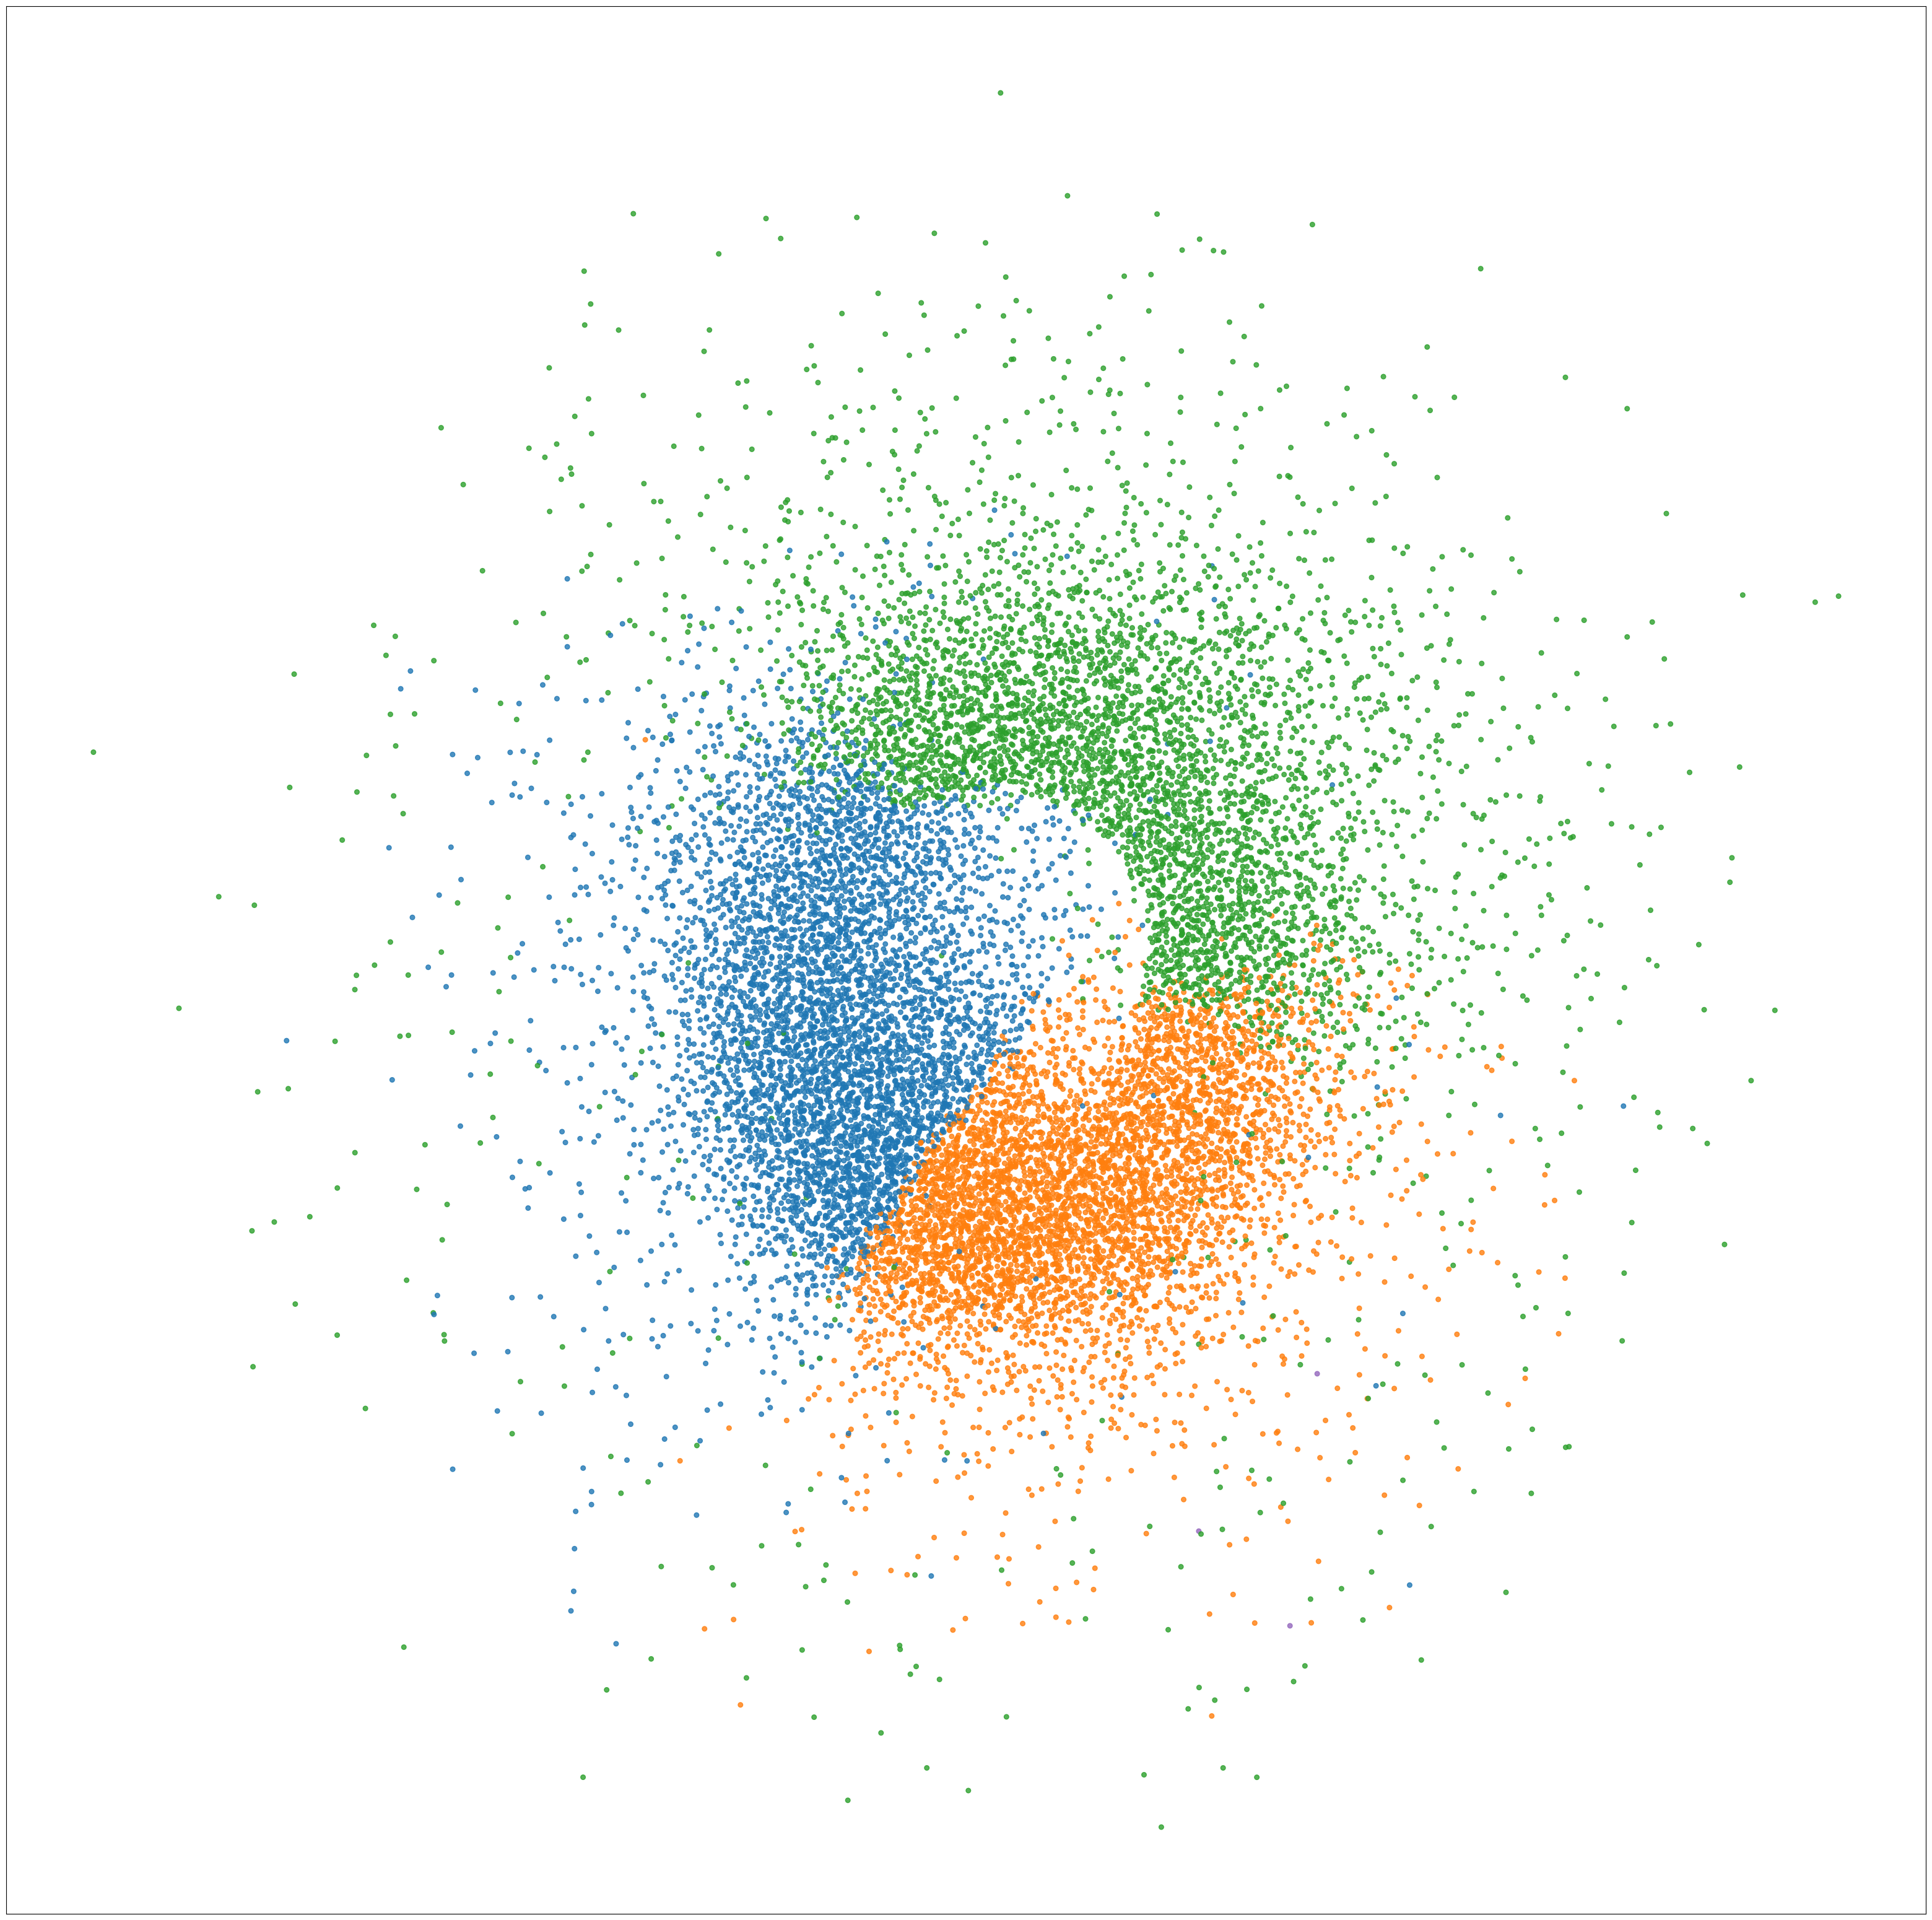

CPU times: user 18min 38s, sys: 1min 49s, total: 20min 28s
Wall time: 19min 32s


In [11]:
%%time
# Draw the graph using the color attribute
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42)  # deterministic layout for reproducibility
# Scale x,y positions
for i in pos:
    pos[i][0] *= 2
    pos[i][1] *= 2
node_colors = [G.nodes[n].get("color", "#333333") for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
#nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
plt.show()

In [ ]:
# Display hardware specifications
import psutil
with open("/proc/cpuinfo") as f:
    cpu_name = next(line.strip().split(": ")[1] for line in f if "model name" in line)
    cpu_name += f" ({psutil.cpu_count(logical=False)} cores)"
print(f"CPU: {cpu_name}")
try:
    import cupy as cp
    if cp.cuda.is_available():
        gpu_name = cp.cuda.runtime.getDeviceProperties(0)["name"].decode("utf-8")
        gpu_memory = cp.cuda.runtime.getDeviceProperties(0)["totalGlobalMem"] / (1024 ** 3)
        print(f"GPU: {gpu_name}")
        print(f"GPU Memory: {gpu_memory:.2f} GB")
except ImportError:
    pass

CPU: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz (6 cores)
GPU: Quadro RTX 8000
GPU Memory: 47.45 GB


---
<i>
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
<i>
<br>
<br>
<i>
Information on the gene expression dataset used in this notebook is as follows:
<br>Alvira, Cristina (2023). Gene expression csv files. figshare. Dataset. https://doi.org/10.6084/m9.figshare.21861975.v1
</i>
